In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
%config InlineBackend.figure_format = 'retina'

# Reprducting the results
> Measuring Incompatibility & Clustering Quantum Observables (PRL 130, 170201)

This notebook reproduces the paper's analytic incompatibility computations and example clustering of qubit observables using the helper class in `compatibility_tools.py`.


## Loading necessary Packages

In [7]:
%load_ext autoreload
%autoreload 2
from compatibility_tools import CompatibilityMeasure, ClusteringToolkit
from qutip import *
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Observables with no noise

### Generate Observables

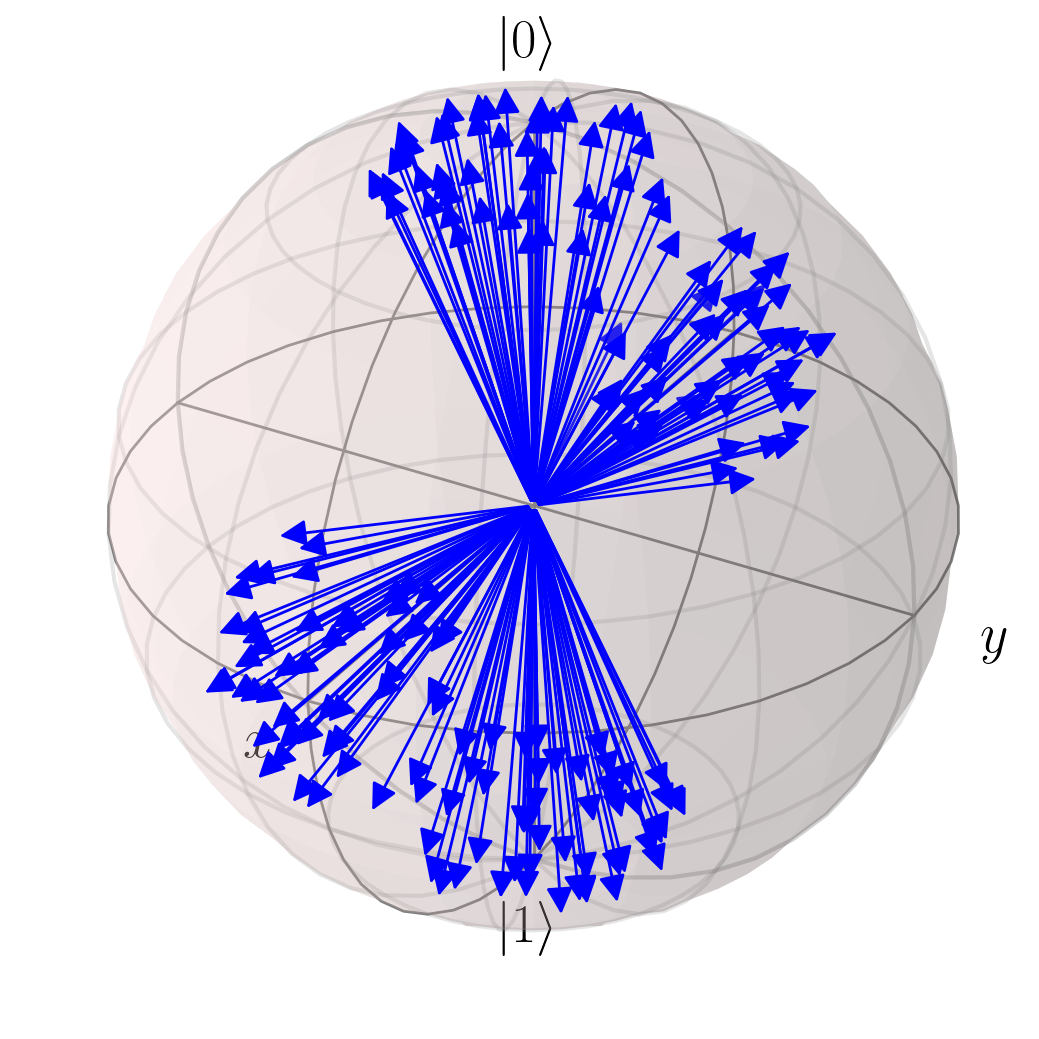

In [13]:
n = 100  # number of observables
vectors_around_x = cm.sample_unit_vectors_cone(n//2, theta_deg=22.5, axis=[1,0,0], rng=np.random.default_rng(42))
vectors_around_z = cm.sample_unit_vectors_cone(n//2, theta_deg=22.5, axis=[0,0,1], rng=np.random.default_rng(43))


# Normalize all vectors to unit length
vectors_around_x = vectors_around_x / np.linalg.norm(vectors_around_x, axis=1, keepdims=True)
vectors_around_z = vectors_around_z / np.linalg.norm(vectors_around_z, axis=1, keepdims=True)
all_vectors = np.vstack([vectors_around_x, vectors_around_z])

observables = [cm.projective_qubit_povm_from_axis(all_vectors[i]) for i in range(n)]

# Plot the axes of all observables on the Bloch sphere
b = Bloch()
b.vector_color = ['blue'] * (2*n)
b.vector_width = 1
for s in observables:
    b.add_states(s) #type: ignore
b.show()


### Clustering

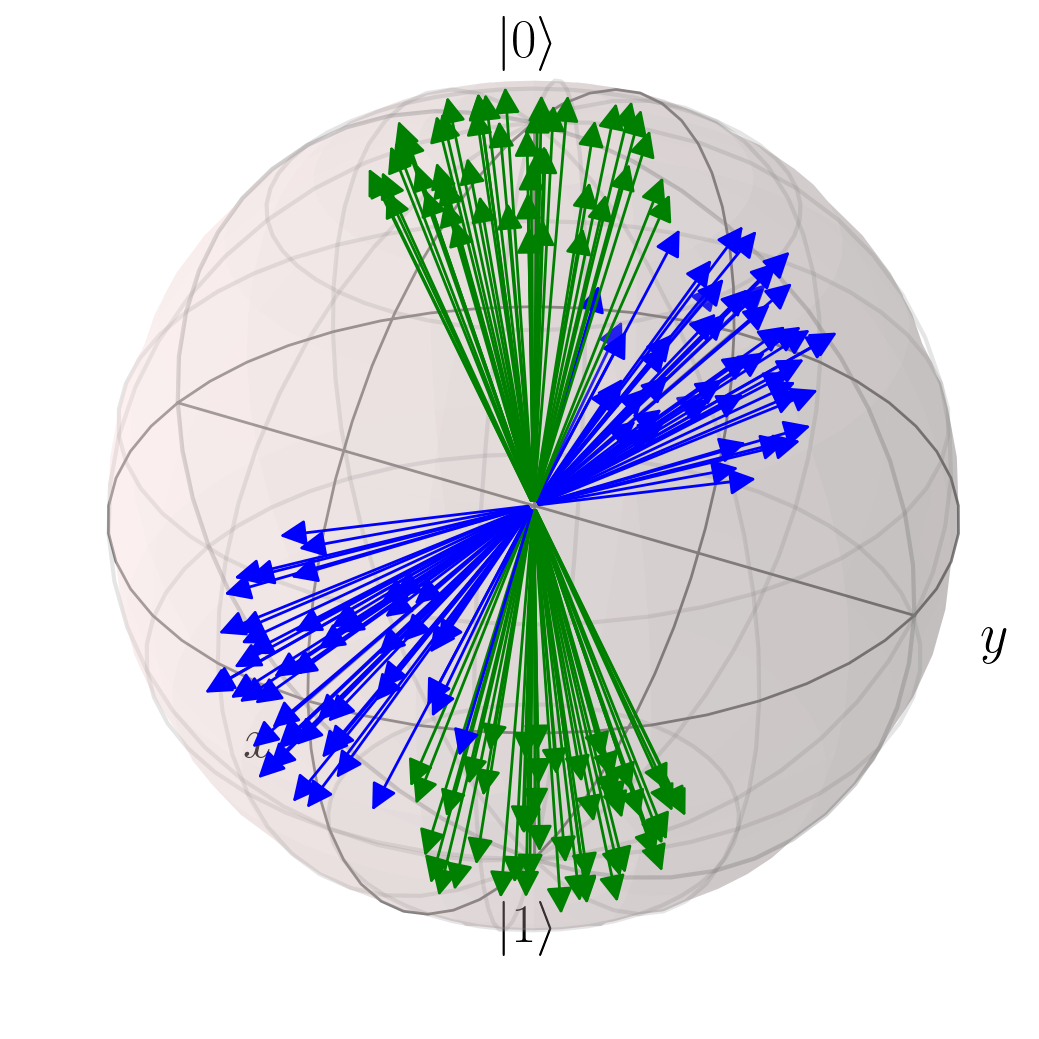

In [14]:
D = cm.incompatibility_distance_matrix(observables)

from compatibility_tools import ClusteringToolkit

labels = ct.cluster_from_distance(D, n_clusters=2, method='kmedoids')

# from sklearn_extra.cluster import KMedoids

# kmedoids = KMedoids(n_clusters=3, metric="precomputed", random_state=0)
# labels = kmedoids.fit_predict(D)

# Plot the axes of all observables on the Bloch sphere
b = Bloch()
b.vector_color = ['b' if labels[i//2]==0 else 'g' for i in range(2*n)]
b.vector_width = 1 
for s in observables:
    b.add_states(s)  # type: ignore
b.show()

os.makedirs("Plots&Data/MLQS", exist_ok=True)
b.fig.savefig("Plots&Data/MLQS/clustered_observables.png", dpi=300)

In [15]:
%load_ext autoreload
%autoreload 2
cm = CompatibilityMeasure(method = 'numerical')
ct = ClusteringToolkit(cm = cm)
spread_angle = 11.25
n_points_per_cluster = 100
dataset = ct.generate_noisy_dataset(n_clusters = 2, noisy = False, spread_angle=spread_angle, n=n_points_per_cluster)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


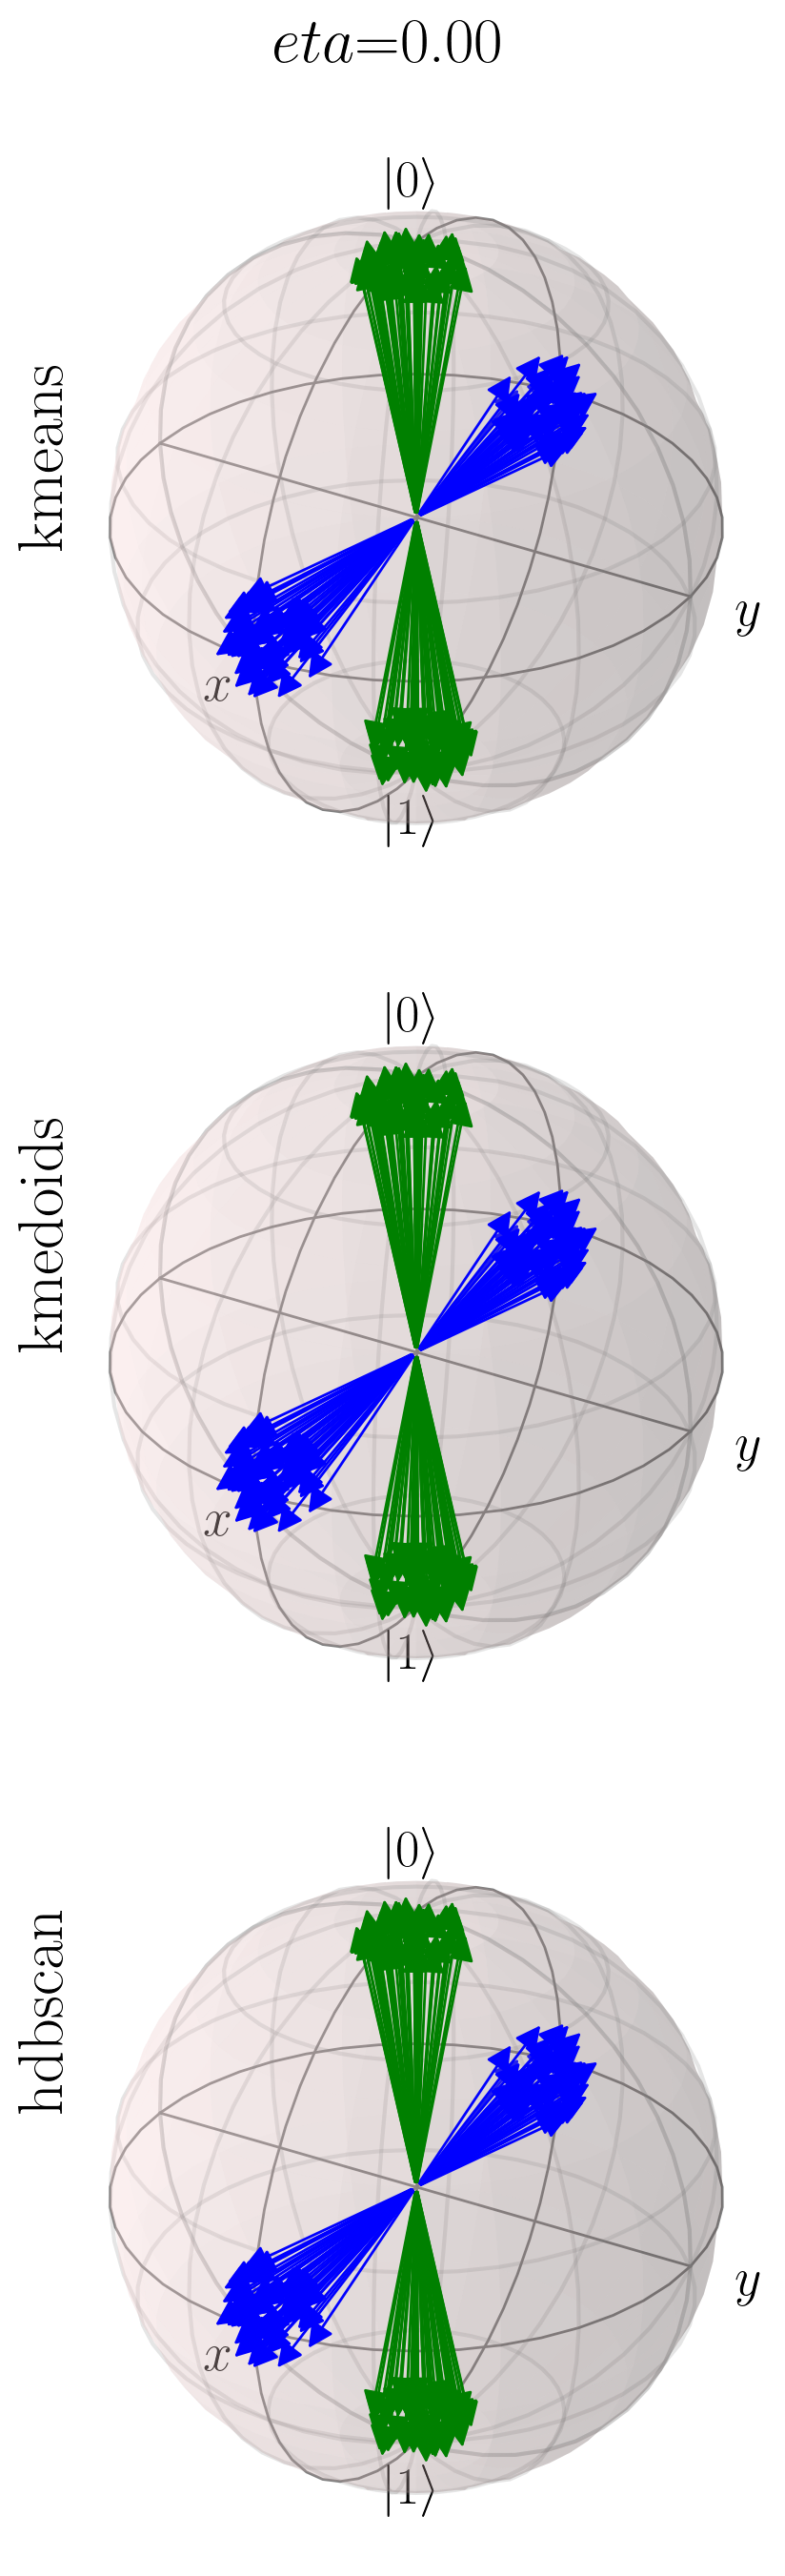

In [16]:
fontsize=24
# set global font sizes
plt.rcParams.update({
    "font.size": fontsize,
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize,
    "xtick.labelsize": int(fontsize * 0.9),
    "ytick.labelsize": int(fontsize * 0.9),
    "legend.fontsize": int(fontsize * 0.9),
})

savepath=f"Plots&Data/MLQS/kmeans_kmedoids_comparison_[{spread_angle:.2f}_noiseless].png"
# savepath = None
methods = ('kmeans','kmedoids', 'hdbscan')
ct.plot_eta_grid_from_dataset(dataset, methods=methods, savepath=savepath, fontsize=fontsize) 

## Noisy Observables

### Generate Observables

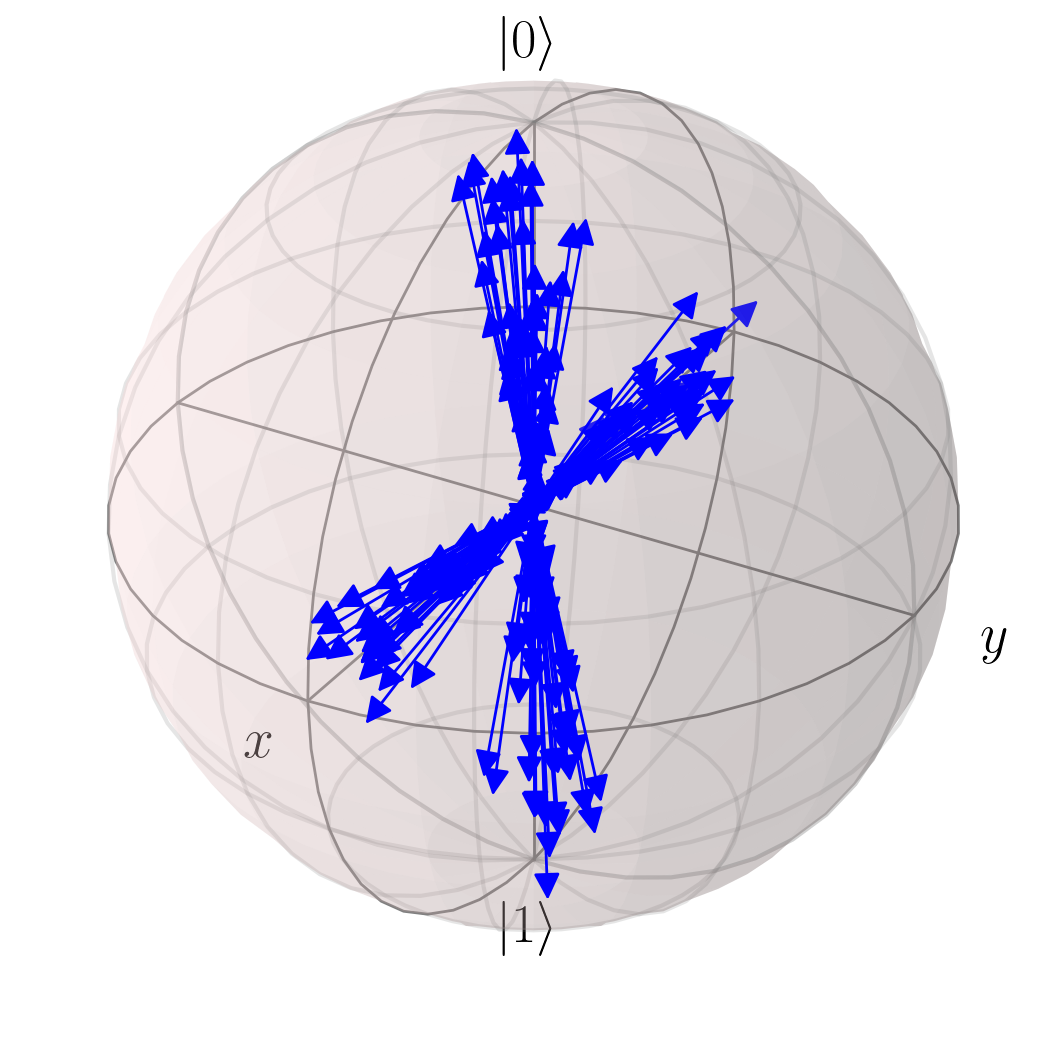

In [54]:
n = 100  # number of observables
spread_angle = 22.5/2  # degrees
vectors_around_x = cm.sample_unit_vectors_cone(n//2, theta_deg=spread_angle, axis=[1,0,0], rng=np.random.default_rng(42))
vectors_around_z = cm.sample_unit_vectors_cone(n//2, theta_deg=spread_angle, axis=[0,0,1], rng=np.random.default_rng(43))

# Normalize all vectors to unit length
vectors_around_x = vectors_around_x / np.linalg.norm(vectors_around_x, axis=1, keepdims=True)
vectors_around_z = vectors_around_z / np.linalg.norm(vectors_around_z, axis=1, keepdims=True)
all_vectors = np.vstack([vectors_around_x, vectors_around_z])

observables = [cm.projective_qubit_povm_from_axis(all_vectors[i]) for i in range(n)]

# Add noise to the observables
max_noise_eta = 0.90
rng = np.random.default_rng(None)
# Sample base_Rl including both endpoints [0, 1]
base_Rl = rng.uniform(low=0, high=1, size=n)
# base_Rl[-1] = 1.0  # explicitly set the last value to the high endpoint
lam = max_noise_eta * base_Rl
noisy_observables, noisy_kraus_ops = [], []
for i, obs in enumerate(observables):
    noisy_obs, noisy_kraus = cm.noisy_povm_with_kraus_qobj(obs, lam=lam[i])
    noisy_observables.append(noisy_obs)
    noisy_kraus_ops.append(noisy_kraus)

# Plot the axes of all observables on the Bloch sphere
b = Bloch()
b.vector_color = ['blue'] * (2*n)
b.vector_width = 1
for s in noisy_observables:
    b.add_states(s) #type: ignore
b.show()


### Clustering

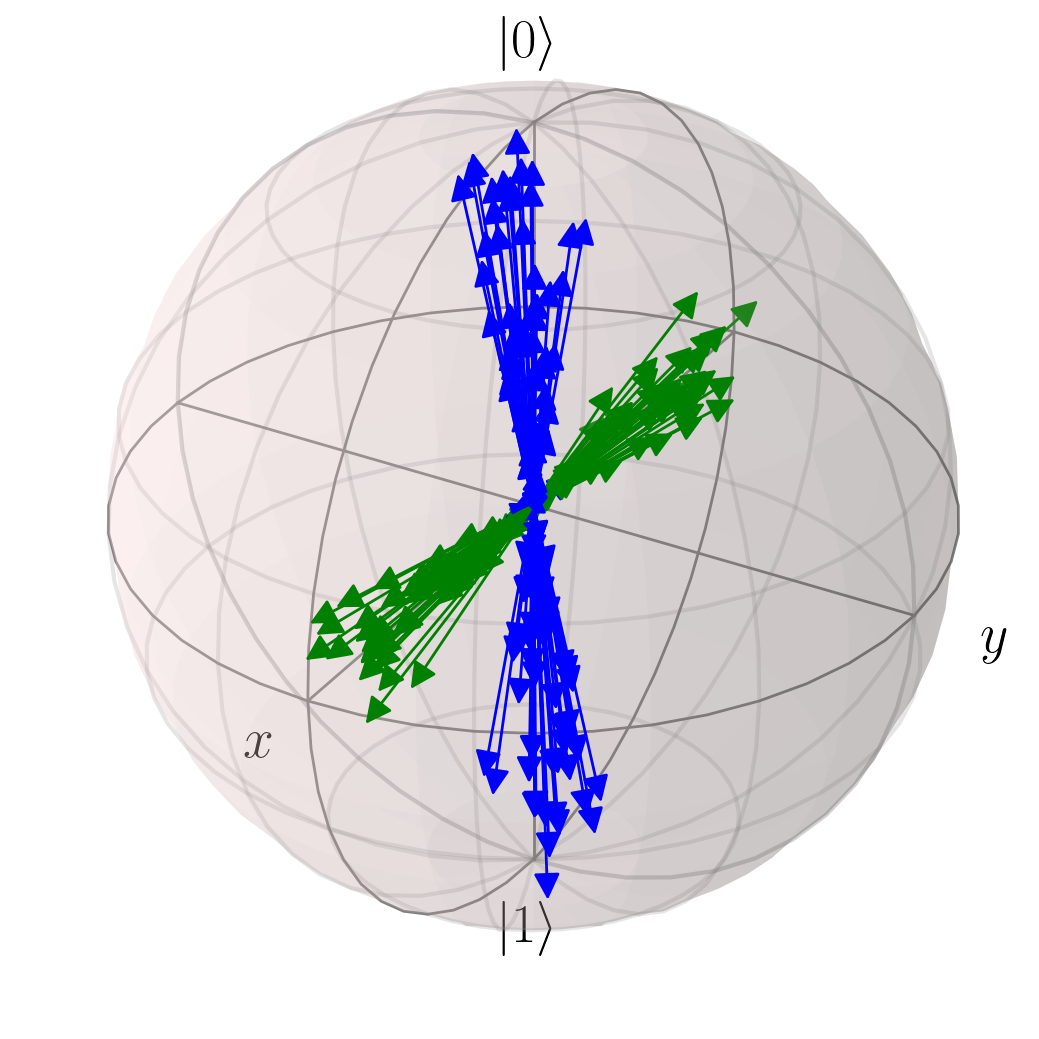

In [56]:
noisy_kraus_ops_flat = [[k for krauses in obs for k in krauses] for obs in noisy_kraus_ops]
D = cm.incompatibility_distance_matrix(noisy_kraus_ops_flat)

from compatibility_tools import ClusteringToolkit

method = 'kmedoids'
method = 'kmeans'

labels = ct.cluster_from_distance(D, n_clusters=2, method=method)

# from sklearn_extra.cluster import KMedoids

# kmedoids = KMedoids(n_clusters=3, metric="precomputed", random_state=0)
# labels = kmedoids.fit_predict(D)

# Plot the axes of all observables on the Bloch sphere
b = Bloch()
b.vector_color = ['b' if labels[i//2]==0 else 'g' for i in range(2*n)]
b.vector_width = 1 
for s in noisy_observables:
    b.add_states(s)  # type: ignore
b.show()

os.makedirs("Plots&Data/MLQS", exist_ok=True)
b.fig.savefig(f"Plots&Data/MLQS/{method}_clustered_noisy_observables_[{spread_angle:.2f}][{max_noise_eta:.2f}].png", dpi=300)

### Comparison

In [18]:
%reload_ext autoreload
# -------- Example run in your notebook --------
n_points_per_cluster = 100  # number of observables
spread_angle = 22.5
etas = [0.25, 0.50, 0.75]
dataset = ct.generate_noisy_dataset(n_clusters=2, etas=etas, methods=('kmeans','kmedoids','hdbscan'), n=n_points_per_cluster, spread_angle=spread_angle)
# ct.save_noisy_dataset(dataset)  # optional

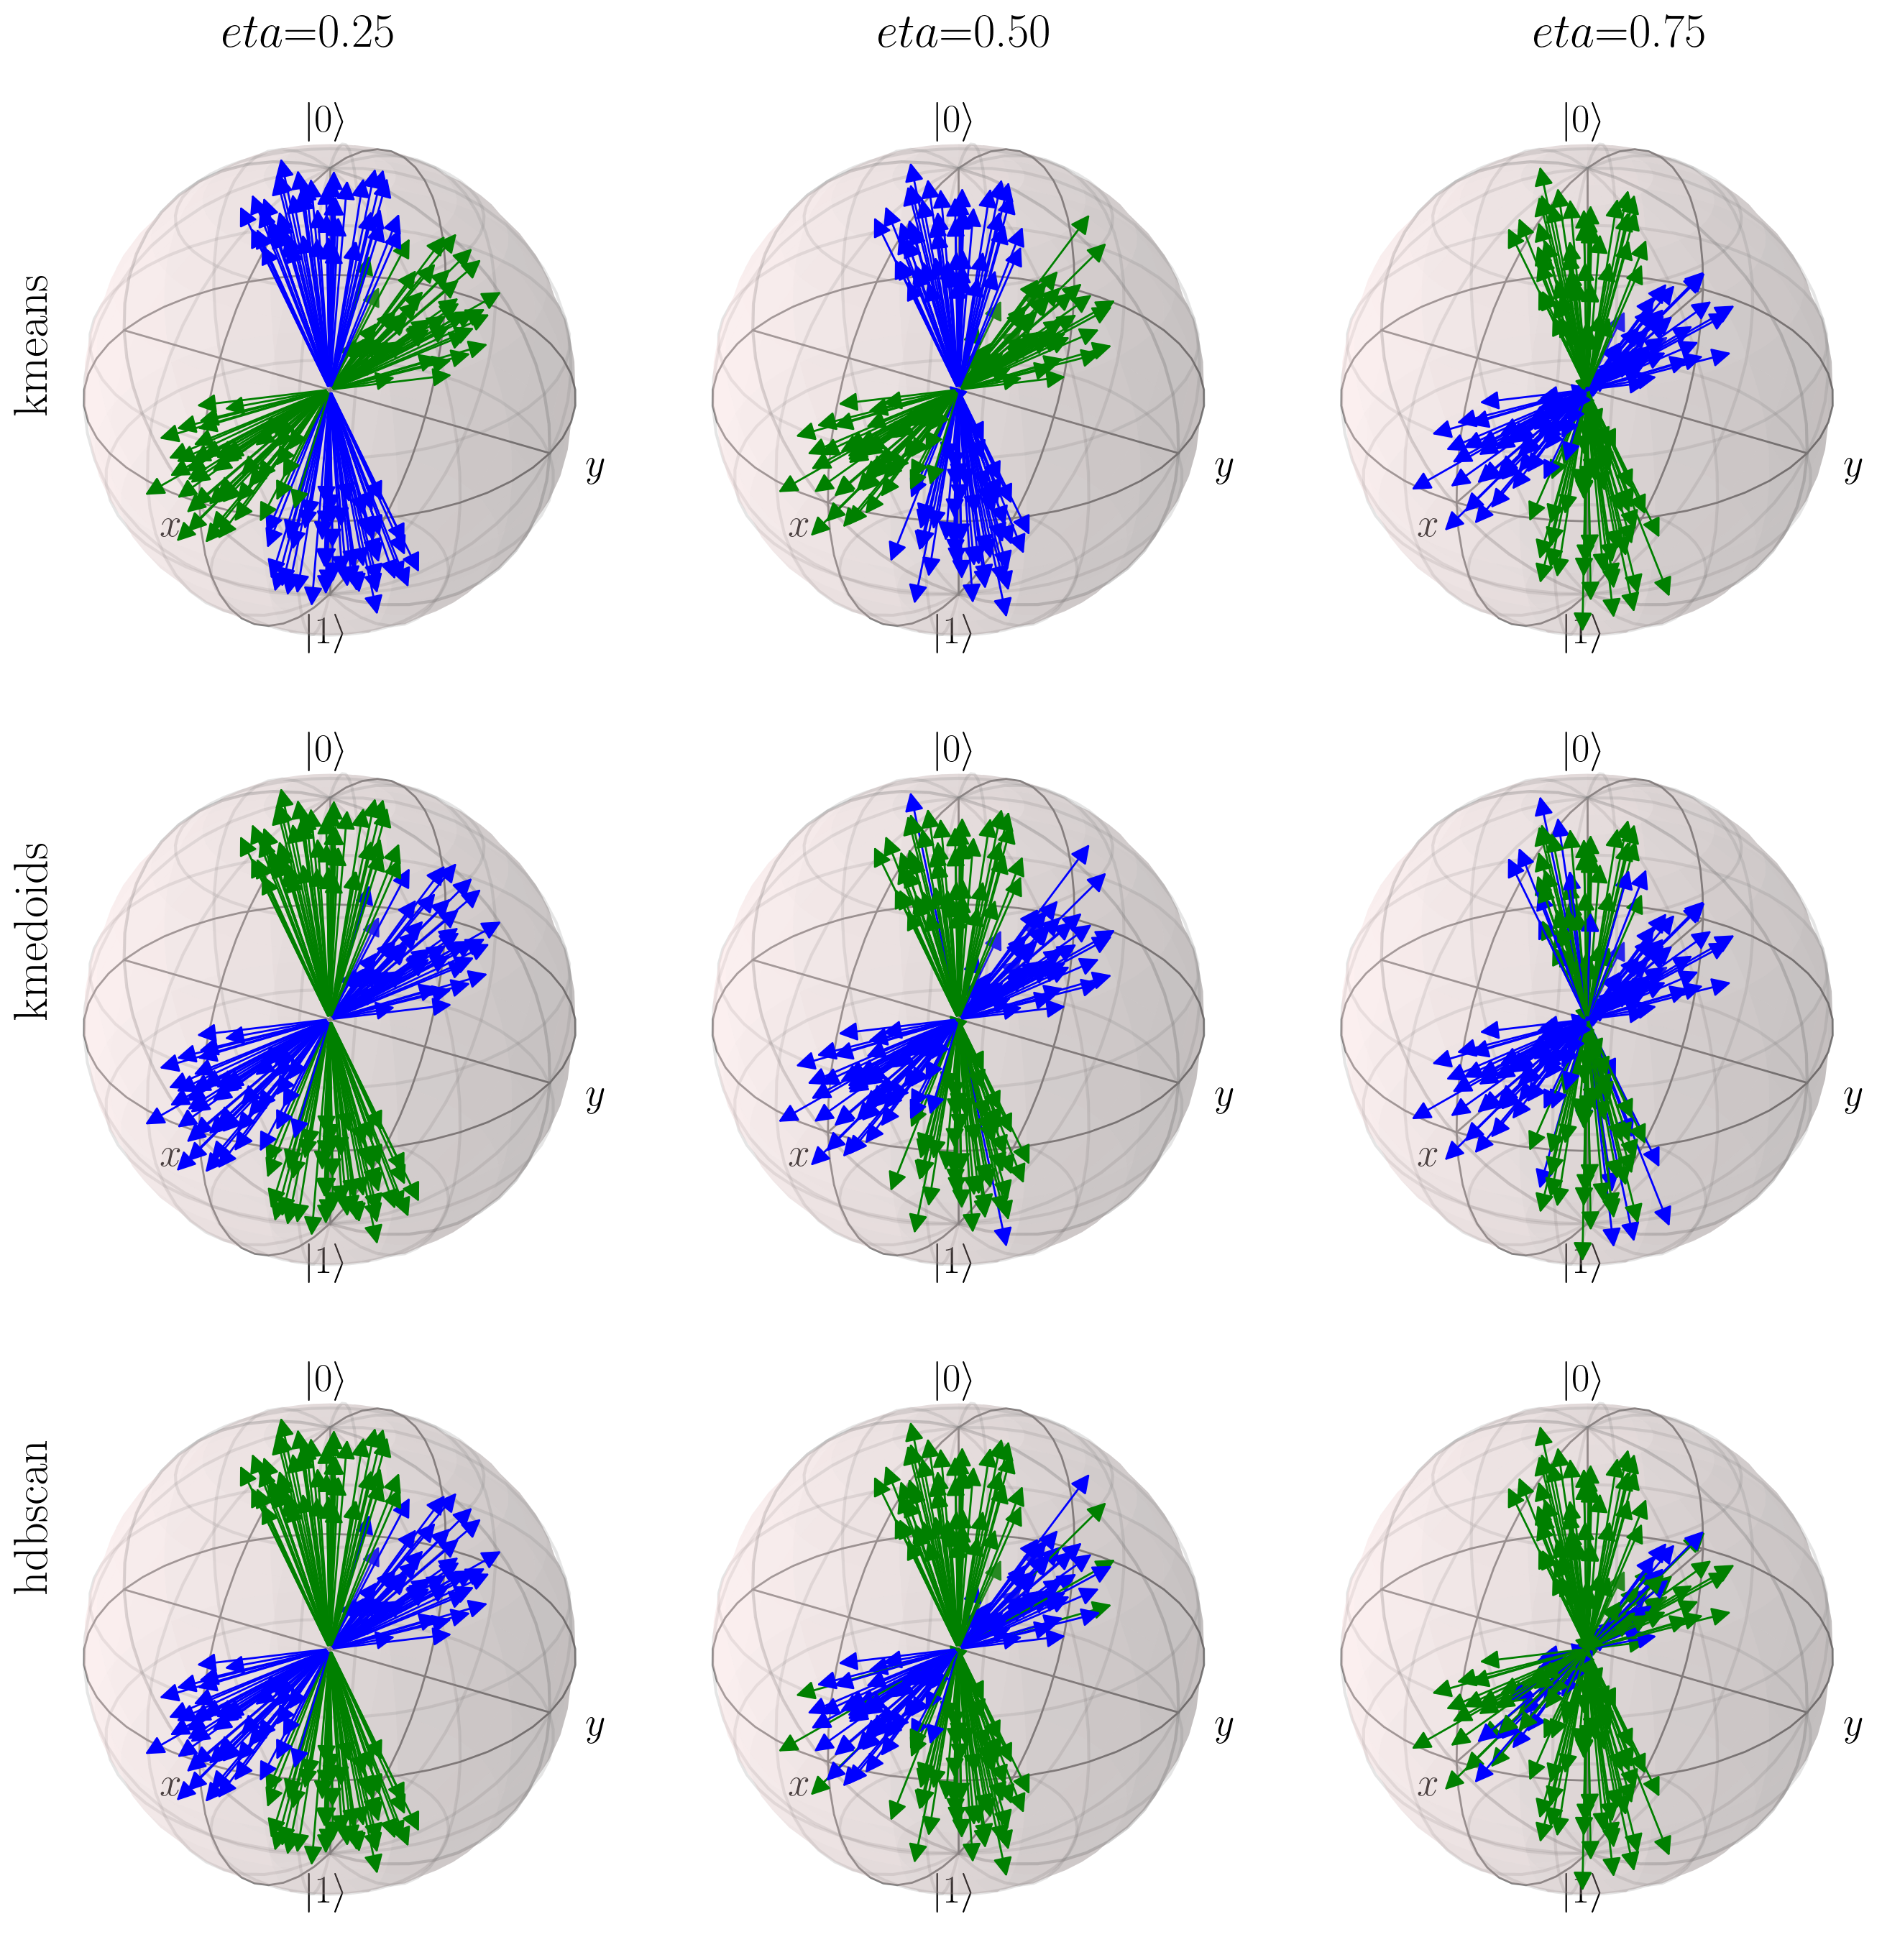

In [19]:
%reload_ext autoreload
fontsize=24
# set global font sizes
plt.rcParams.update({
    "font.size": fontsize,
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize,
    "xtick.labelsize": int(fontsize * 0.9),
    "ytick.labelsize": int(fontsize * 0.9),
    "legend.fontsize": int(fontsize * 0.9),
})

savepath=f"Plots&Data/MLQS/kmeans_kmedoids_comparison_[{spread_angle:.2f}].png"
# savepath = None
methods = ('kmeans','kmedoids', 'hdbscan')
ct.plot_eta_grid_from_dataset(dataset, methods=methods, savepath=savepath, fontsize=fontsize) 